In [1]:
# ==============================================================
# MSc Project – Biometric Security Baseline + Adversarial Testing
# Author: Stella Williams
# Draft 4
# ==============================================================

# --------------------------------------------------------------
# Step 1: Initialise Model & Device
# --------------------------------------------------------------

import torch
import torch.nn as nn
from facenet_pytorch import InceptionResnetV1
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import random, cv2
from PIL import Image
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = InceptionResnetV1(pretrained="vggface2").eval().to(device)

criterion = nn.CosineEmbeddingLoss()
cos = nn.CosineSimilarity(dim=1)


Using device: cpu


In [2]:
# --------------------------------------------------------------
# Step 2: Load & Filter LFW Dataset for 2 Identities
# --------------------------------------------------------------

lfw_path = "/Users/stel/Documents/Dissertation/msc-biometric-security/Datasets/lfw-dataset"

transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor()
])

lfw_full = datasets.ImageFolder(root=lfw_path, transform=transform)

# Pick 2 identities for impersonation attack
selected_classes = random.sample(lfw_full.classes, 2)
source_class, target_class = selected_classes[0], selected_classes[1]
print("Source:", source_class, "| Target:", target_class)

source_indices = [i for i, (_, label) in enumerate(lfw_full) if lfw_full.classes[label] == source_class]
target_indices = [i for i, (_, label) in enumerate(lfw_full) if lfw_full.classes[label] == target_class]

source_loader = DataLoader(Subset(lfw_full, source_indices), batch_size=1, shuffle=True)
target_loader = DataLoader(Subset(lfw_full, target_indices), batch_size=1, shuffle=True)



Source: Doug_Christie | Target: Rod_Jong-il


In [3]:
# --------------------------------------------------------------
# Step 3: PGD Attack for Impersonation (Targeted)
# --------------------------------------------------------------

def impersonation_pgd_v3(model, source_img, target_img, eps=0.2, alpha=0.01, steps=40):
    source_img = source_img.to(device)
    target_embed = model(target_img.to(device)).detach()
    adv = source_img.clone().detach().requires_grad_(True).to(device)

    for _ in range(steps):
        adv_embed = model(adv)
        sim = cos(adv_embed, target_embed)
        loss = -sim  # Try direct negative cosine similarity
        model.zero_grad(); loss.backward()
        grad = adv.grad

        # Raw gradient update
        adv = adv + alpha * grad / (grad.norm() + 1e-8)
        adv = torch.clamp(source_img + torch.clamp(adv - source_img, -eps, eps), 0, 1).detach_()
        adv.requires_grad = True

    return adv




In [4]:
# --------------------------------------------------------------
# Step 4: Run One Impersonation Test (Visual + Cosine)
# --------------------------------------------------------------

source_img, _ = next(iter(source_loader))
target_img, _ = next(iter(target_loader))
# Alias for readability (no logic change)
impersonation_pgd = impersonation_pgd_v3

adv_img = impersonation_pgd(model, source_img, target_img, eps=0.2, alpha=0.01, steps=40)



embed_src = model(source_img.to(device))
embed_tgt = model(target_img.to(device))
embed_adv = model(adv_img)

print("Cosine similarity (original vs target):", cos(embed_src, embed_tgt).item())
print("Cosine similarity (adversarial vs target):", cos(embed_adv, embed_tgt).item())




Cosine similarity (original vs target): -0.4311928153038025
Cosine similarity (adversarial vs target): -0.5357238054275513


In [5]:
# --------------------------------------------------------------
# Analysis Step 1: Authentication Decision Rule
# This converts “numbers” into authentication outcomes, which is what biometric systems actually do. a bridge from ML to security.
# --------------------------------------------------------------

# Typical FaceNet verification thresholds reported in literature
# (varies by dataset; 0.5–0.8 common, i choose conservatively)
AUTH_THRESHOLD = 0.8

sim_src_tgt = cos(embed_src, embed_tgt).item()
sim_adv_tgt = cos(embed_adv, embed_tgt).item()

def auth_decision(similarity, threshold=AUTH_THRESHOLD):
    return "ACCEPT" if similarity >= threshold else "REJECT"

print(f"Authentication threshold: {AUTH_THRESHOLD}")
print(f"Original vs Target: {sim_src_tgt:.4f} → {auth_decision(sim_src_tgt)}")
print(f"Adversarial vs Target: {sim_adv_tgt:.4f} → {auth_decision(sim_adv_tgt)}")


Authentication threshold: 0.8
Original vs Target: -0.4312 → REJECT
Adversarial vs Target: -0.5357 → REJECT


In [6]:
# --------------------------------------------------------------
# Analysis Step 2: Quantitative Attack Impact
# Was this an evasion or an impersonation success?
# --------------------------------------------------------------

delta_similarity = sim_adv_tgt - sim_src_tgt

print("Change in similarity due to attack:", round(delta_similarity, 4))

if sim_adv_tgt < AUTH_THRESHOLD:
    print("Result: Pixel-space attack failed to bypass authentication.")
else:
    print("Result: Pixel-space attack succeeded in impersonation.")


Change in similarity due to attack: -0.1045
Result: Pixel-space attack failed to bypass authentication.


In [7]:
# --------------------------------------------------------------
# Analysis Step 3: Log Results for Reporting
# --------------------------------------------------------------

results = {
    "attack_type": "Pixel-space PGD (targeted)",
    "epsilon": 0.2,
    "steps": 40,
    "source_target_similarity": sim_src_tgt,
    "adversarial_target_similarity": sim_adv_tgt,
    "authentication_threshold": AUTH_THRESHOLD,
    "authentication_outcome": auth_decision(sim_adv_tgt),
}

for k, v in results.items():
    print(f"{k}: {v}")


attack_type: Pixel-space PGD (targeted)
epsilon: 0.2
steps: 40
source_target_similarity: -0.4311928153038025
adversarial_target_similarity: -0.5357238054275513
authentication_threshold: 0.8
authentication_outcome: REJECT


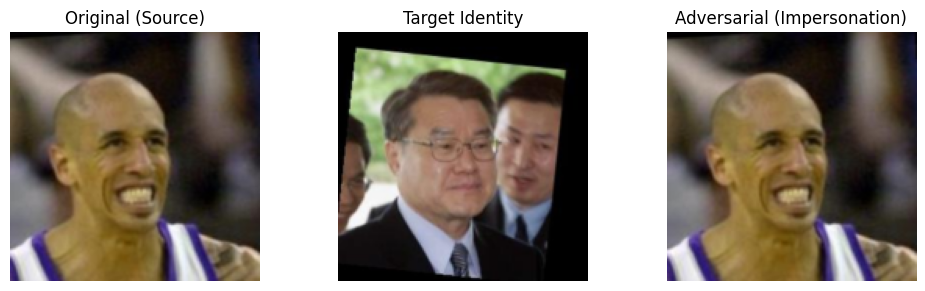

In [8]:
# --------------------------------------------------------------
# Step 5: Visualise Impersonation Attempt
# --------------------------------------------------------------

def show(img, title="Image"):
    plt.imshow(img.squeeze().permute(1,2,0).detach().cpu())
    plt.title(title)
    plt.axis("off")

plt.figure(figsize=(10,3))
plt.subplot(1,3,1); show(source_img, "Original (Source)")
plt.subplot(1,3,2); show(target_img, "Target Identity")
plt.subplot(1,3,3); show(adv_img, "Adversarial (Impersonation)")
plt.tight_layout()
plt.show()

